In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
# import time
# import h5py
# import ants
# import nibabel as nib
# import matplotlib
# from scipy.ndimage import gaussian_filter1d
# from scipy.fftpack import fft,fftshift,ifft
# from scipy import signal
# import pickle

/home/users/yandanw/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle

In [3]:
fly = 'fly_134'#'fly_153'#'fly_147'#'fly_152'#'fly_134'
anat_to_mean_type = 'myr'#'non_myr'
av_thresh = 50 #100 #50 #100
#standard
stim_start = 250
stim_stop = 300
# stim_start = 300
# stim_stop = 350

In [36]:
# 8 good flies: 116,122,134,292,294,296
# out of the 8 flies, there are 4 flies have 3 stimulus patterns(0-180,180-0,middle to lateral)
# and they are 154,292,294, and 296.
# all those flies are with GcAMP6f
# there are good flies with good behavior and neural imaging data but with GcAMP8s
# 153,152,149,143

In [4]:
func_path = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/{fly}/func_0/'

In [42]:
def extract_stim_times_from_pd(photodiode_trace, time_vector):
	threshold=0.8,
	command_frame_rate=120
	sample_rate = 10000
	minimum_epoch_separation = 0.9 * (1 + 0) * sample_rate

	# shift & normalize so frame monitor trace lives on [0 1]
	photodiode_trace = photodiode_trace - np.min(photodiode_trace)
	photodiode_trace = photodiode_trace / np.max(photodiode_trace)

	# find frame flip times
	V_orig = photodiode_trace[0:-2]
	V_shift = photodiode_trace[1:-1]
	ups = np.where(np.logical_and(V_orig < threshold, V_shift >= threshold))[0] + 1
	downs = np.where(np.logical_and(V_orig >= threshold, V_shift < threshold))[0] + 1
	frame_times = np.sort(np.append(ups, downs))

	# Use frame flip times to find stimulus start times
	stimulus_start_frames = np.append(0, np.where(np.diff(frame_times) > minimum_epoch_separation)[0] + 1)
	stimulus_end_frames = np.append(np.where(np.diff(frame_times) > minimum_epoch_separation)[0], len(frame_times)-1)
	stimulus_start_times = frame_times[stimulus_start_frames] / sample_rate  # datapoints -> sec
	stimulus_end_times = frame_times[stimulus_end_frames] / sample_rate  # datapoints -> sec

	stim_durations = stimulus_end_times - stimulus_start_times # sec
	return stimulus_start_times, stim_durations, stimulus_end_times

In [43]:
#####Yandan Trying#########
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times, stim_durations, stimulus_end_times = extract_stim_times_from_pd(pd2, t)

### Get Metadata ###
stim_ids, angles = brainsss.get_stimulus_metadata(vision_path)
print(F"Found {len(stim_ids)} presented stimuli.")

# *100 puts in units of 10ms, which will match fictrac
starts_angle = {}
for angle in [0,180]:
    starts_angle[angle] = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == angle]
print(F"starts_angle_0: {len(starts_angle[0])}. starts_angle_180: {len(starts_angle[180])}")

# get 1ms version to match neural timestamps
starts_angle_ms = {}
for angle in [0,180]:
    starts_angle_ms[angle] = [i*10 for i in starts_angle[angle]]

loading photodiode data... done
Loaded from Pickle.
Found 753 presented stimuli.
starts_angle_0: 374. starts_angle_180: 374


In [55]:
stimulus_start_times[2]

64.6315

In [58]:
stimulus_start_times[2]-stimulus_end_times[1]

1.2834000000000003

In [56]:
stim_durations[2]

0.7583999999999946

In [57]:
stimulus_end_times[2]

65.3899

In [5]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)

### Get Metadata ###
stim_ids, angles = brainsss.get_stimulus_metadata(vision_path)
print(F"Found {len(stim_ids)} presented stimuli.")

# *100 puts in units of 10ms, which will match fictrac
starts_angle = {}
for angle in [0,180]:
    starts_angle[angle] = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times)) if angles[i] == angle]
print(F"starts_angle_0: {len(starts_angle[0])}. starts_angle_180: {len(starts_angle[180])}")

# get 1ms version to match neural timestamps
starts_angle_ms = {}
for angle in [0,180]:
    starts_angle_ms[angle] = [i*10 for i in starts_angle[angle]]

loading photodiode data... done
Loaded from Pickle.
Found 753 presented stimuli.
starts_angle_0: 374. starts_angle_180: 374


In [19]:
stimulus_start_times[-1]

1734.4743

In [27]:
stimulus_start_times[0:10] # in s

array([ 1.3092, 62.5897, 64.6315, 66.6734, 68.7152, 70.7571, 72.8072,
       74.8408, 76.8826, 78.9245])

In [21]:
starts_angle[0][0:10] # in 10ms

[6258, 6667, 7075, 7688, 7892, 8504, 8708, 9116, 9728, 10136]

In [26]:
fictrac_timestamps[0:10] # in unit of 10ms

array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.])

In [25]:
stimulus_start_times[0:10] # in second

array([ 1.3092, 62.5897, 64.6315, 66.6734, 68.7152, 70.7571, 72.8072,
       74.8408, 76.8826, 78.9245])

In [6]:
####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [40]:
len(fictrac_timestamps)

180000

In [7]:
#### from brainsss ###
def extract_traces(fictrac, stim_times, pre_window, post_window, beh):
    traces = []
    for i in range(len(stim_times)):
        trace = fictrac[beh][stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace
######################

In [8]:
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################
beh = 'Z'

pre_window = 200
post_window = 300#400

behavior_traces = {}
mean_trace = {}
sem_trace = {}
for angle in [0,180]:
    behavior_traces[angle],mean_trace[angle],sem_trace[angle] = extract_traces(fictrac,
                                                                                starts_angle[angle],
                                                                                pre_window,
                                                                                post_window,
                                                                                beh)
    
### repeat for forward velocity
beh = 'Y'

behavior_traces_F = {}
mean_trace_F = {}
sem_trace_F = {}
for angle in [0,180]:
    behavior_traces_F[angle],mean_trace_F[angle],sem_trace_F[angle] = extract_traces(fictrac,
                                                                                starts_angle[angle],
                                                                                pre_window,
                                                                                post_window,
                                                                                beh)

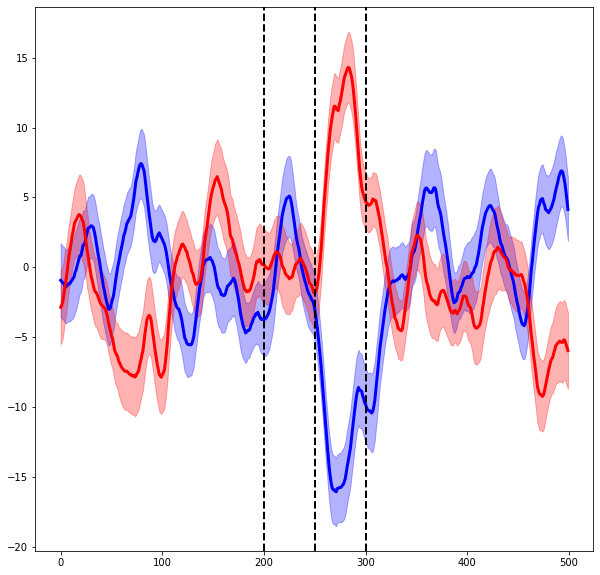

In [9]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    plt.plot(mean_trace[angle],color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_trace[angle])),mean_trace[angle]-sem_trace[angle], mean_trace[angle]+sem_trace[angle], color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
# save_path = '/oak/stanford/groups/trc/data/yandan/2P_Imaging/optomotor_response_analysis'
# save_file = os.path.join(save_path,"figs",'fly_134_mean_trace')
# plt.savefig(save_file,dpi=300,bbox_inches="tight",transparent=False)

In [8]:
# # ### ve based on derivative sum.
# # ### I would like to assign a number to "turn quality"

# start = 300
# end = 350
# angle = 0

# behavior_traces_clipped = np.clip(behavior_traces[angle],None,0)
# traces_derivative = np.subtract(behavior_traces_clipped[:,:-1], behavior_traces_clipped[:,1:])
# #traces_derivative = np.clip(traces_derivative,None,0)
# turn_amount = np.sum(traces_derivative[:,start:end],axis=-1)
# sorted_indicies = np.argsort(turn_amount)
# sorted_traces = behavior_traces[angle][sorted_indicies,:]

# plt.figure(figsize=(10,10))
# plt.imshow(sorted_traces,aspect=5,cmap='seismic',vmin=-300,vmax=300)
# plt.axvline(300,color='k',linestyle='--',lw=2)
# plt.axvline(350,color='k',linestyle='--',lw=2)

In [10]:

############### from brainsss ###############
def get_visually_evoked_turns(traces, mean_turn, start, stop, r_thresh, av_thresh, stim_times, expected_direction):
    ### this will flip the sign of the trace to get the correct av_thresh comparison
    if expected_direction == 'pos':
        flip = 1
    elif expected_direction == 'neg':
        flip = -1


    mean_trace = mean_turn[start:stop] * flip * -1
    
    ### calculate correlation of each turn to mean turn within a defined window
    rs = []
    for i in range(traces.shape[0]):
        rs.append(scipy.stats.pearsonr(mean_trace, traces[i,start:stop])[0])
    
    turns = []
    stim_evoked_turn_times = []
    indicies = []
    for i in range(traces.shape[0]):
        if rs[i]>r_thresh:
            if max(traces[i,start:stop]*flip) > av_thresh:
                turns.append(traces[i,:])
                stim_evoked_turn_times.append(stim_times[i])
                indicies.append(i)
    turns = np.asarray(turns)
    return turns, stim_evoked_turn_times, indicies
################################################

In [11]:
#####################################
### Extract Visually Evoked Turns ###
#####################################
#fly 134
#r_thresh=.3, 
#av_thresh=50,

mean_turn = (mean_trace[0] + mean_trace[180]*-1)/2

ve_turns = {}
ve_turn_times = {}
ve_turn_indicies = {}
for angle,direction in zip([0,180],['neg','pos']):
    ve_turns[angle], ve_turn_times[angle], ve_turn_indicies[angle] =  get_visually_evoked_turns(
                                                                      behavior_traces[angle],
                                                                      mean_turn = mean_turn,
                                                                      start=stim_start, 
                                                                      stop=stim_stop, 
                                                                      r_thresh=.2, 
                                                                      av_thresh=av_thresh, 
                                                                      stim_times=starts_angle_ms[angle],
                                                                      expected_direction=direction)

In [46]:
#Extract Stimulus Triggered Behavior:
    #This block is concerned with summarizing general behavior (like movement patterns) 
    #in response to visual stimuli at different angles.
    #This is a broad analysis looking at overall behavioral changes around the time of 
    #stimulus presentation.
#Extract Visually Evoked Turns:
    #This block is more focused and specific. 
    #It aims to identify and analyze turns that are directly evoked by the 
    #visual stimuli.
    #This code uses thresholds (r_thresh and av_thresh) to identify significant turning
    #behaviors that are likely a direct response to the visual stimuli.
    #The analysis is more refined here, focusing not just on general behavior but on 
    #specific actions (turns) that are evoked by the stimuli.

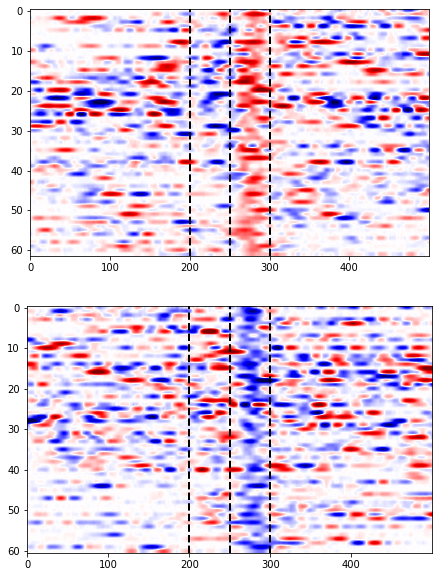

In [12]:
fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.imshow(ve_turns[180],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.subplot(212)
plt.imshow(ve_turns[0],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

Text(0.5, 1.0, 'ffly_134_mean_ve_trace')

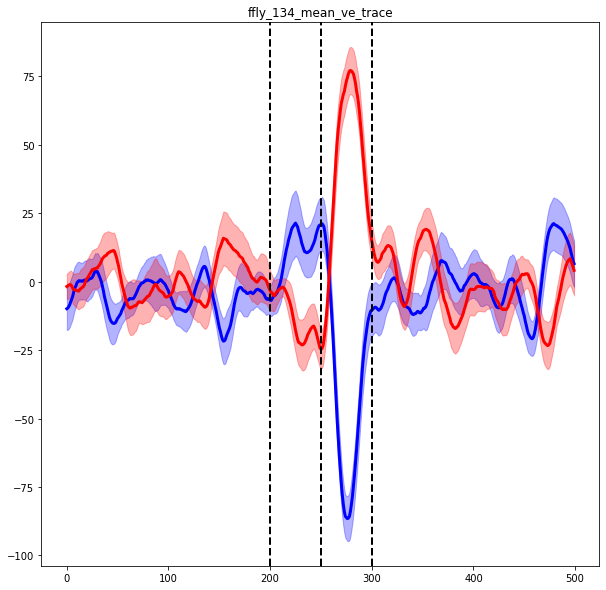

In [13]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    mean_ve_trace = np.mean(ve_turns[angle],axis=0)
    sem_ve_trace = scipy.stats.sem(ve_turns[angle],axis=0)
    
    plt.plot(mean_ve_trace,color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_ve_trace)),mean_ve_trace-sem_ve_trace, mean_ve_trace+sem_ve_trace, color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
plt.title(F'ffly_134_mean_ve_trace')
# save_path = '/oak/stanford/groups/trc/data/yandan/2P_Imaging/optomotor_response_analysis'
# save_file = os.path.join(save_path,"figs",'fly_134_mean_ve_trace')
# plt.savefig(save_file,dpi=300,bbox_inches="tight",transparent=False)    

In [14]:
def get_stimuli_where_no_behavior(traces, start, stop, num_traces_to_return, stim_times):
    amount_of_behavior = np.mean(np.abs(traces[:,start:stop]),axis=-1)
    indicies = np.argsort(amount_of_behavior)
    top_x_indicies = indicies[:num_traces_to_return]
    return traces[top_x_indicies,:], np.asarray(stim_times)[top_x_indicies]

In [15]:
# how do I get block times?
# a block should be 6.25min + 1min grey
# however each stim is actually a little longer than 2s, so 7.45 ends up cutting well
block_dur = 7.45 * 60 * 1000 # in ms
expt_len = 30 * 60 * 1000
block_edge_times = np.arange(0,expt_len,block_dur)
num_blocks = len(block_edge_times) - 1

# now I want to know how many ve turns came from each block
ve_block_ids = {}
all_traces_block_ids = {}
for angle in [0,180]:
    ve_block_ids[angle] = np.searchsorted(block_edge_times,ve_turn_times[angle])
    all_traces_block_ids[angle] = np.searchsorted(block_edge_times,starts_angle_ms[angle])
    
# now for each block, get the same number of no_ve as ve
# Take the ones with the least behavior, but this could be a problem if there is a lot of behavior
ve_no_turns = {}
ve_no_turn_times = {}
for angle in [0,180]:
    trace_length = behavior_traces[angle].shape[1]
    #will append each block to these empty arrays
    ve_no_turns[angle] = np.empty((0,trace_length))
    ve_no_turn_times[angle] = np.empty((0))
    for block_num in range(1,num_blocks+1): # because blocks are not 0 indexed
        block_mask = all_traces_block_ids[angle] == block_num
        
        traces_no_turn, times_no_turn = get_stimuli_where_no_behavior(
            behavior_traces[angle][block_mask,:],
            start=stim_start,
            stop=stim_stop,
            # LOOK - asking for a few less with the 1.5
            num_traces_to_return=int(np.sum(ve_block_ids[angle]==block_num)), # get the same number as ve_turns
            stim_times=np.asarray(starts_angle_ms[angle])[block_mask]
        )
        
        ve_no_turns[angle] = np.concatenate((ve_no_turns[angle],traces_no_turn),axis=0)
        ve_no_turn_times[angle] = np.concatenate((ve_no_turn_times[angle],times_no_turn),axis=0)

In [17]:
ve_no_turn_indicies

NameError: name 've_no_turn_indicies' is not defined

In [16]:
# lets check what stimuli happen during the trial before the optomotor response
# it looks like it is enriched in opposite turns

stimulus_start_times_ms = np.asarray([int(i*100)*10 for i in stimulus_start_times])
for angle in [0,180]:
    stim_idxs = []
    for turn_time in ve_turn_times[0]:
        stim_idx = np.where(turn_time==stimulus_start_times_ms)[0][0]
        stim_idxs.append(angles[stim_idx-1])
    stim_idxs = np.asarray(stim_idxs)
    print(np.sum(stim_idxs==0) / np.sum(stim_idxs==180))


0.5945945945945946
0.5945945945945946


In [52]:
# 180 opto response has 3x more movement in 0 on the trial before


In [53]:
# this is if we don't care about blocks
# ve_no_turns = {}
# ve_no_turn_times = {}
# for angle in [0,180]:
#     ve_no_turns[angle], ve_no_turn_times[angle] = get_stimuli_where_no_behavior(behavior_traces[angle],
#                                   start=stim_start,
#                                   stop=stim_stop,
#                                   num_traces_to_return=len(ve_turns[angle]), # get the same number as ve_turns
#                                   stim_times=starts_angle_ms[angle])

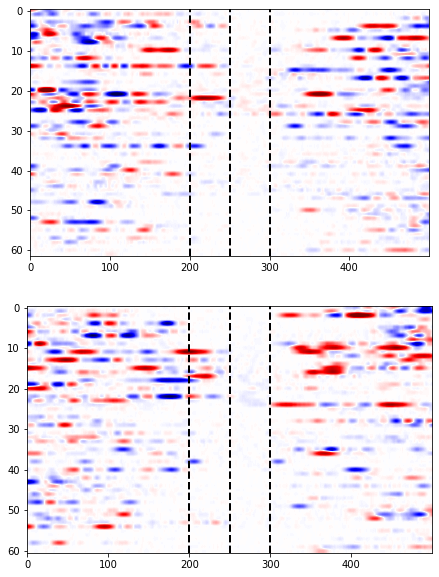

In [17]:
fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.imshow(ve_no_turns[180],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.subplot(212)
plt.imshow(ve_no_turns[0],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

(-50.0, 50.0)

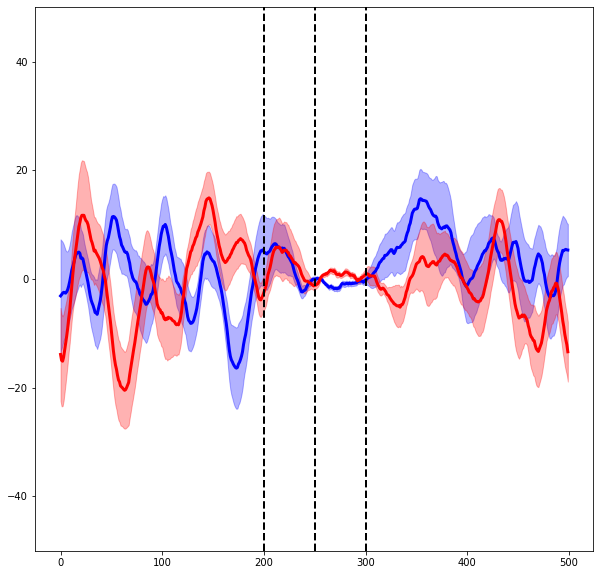

In [18]:
plt.figure(figsize=(10,10))

for angle,color in zip([0,180],['blue','red']):
    mean_ve_trace = np.mean(ve_no_turns[angle],axis=0)
    sem_ve_trace = scipy.stats.sem(ve_no_turns[angle],axis=0)
    
    plt.plot(mean_ve_trace,color=color,linewidth=3)
    plt.fill_between(np.arange(len(mean_ve_trace)),mean_ve_trace-sem_ve_trace, mean_ve_trace+sem_ve_trace, color=color,alpha=0.3)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.ylim(-50,50)
# save_path = '/oak/stanford/groups/trc/data/yandan/2P_Imaging/optomotor_response_analysis'
# save_file = os.path.join(save_path,"figs",'fly_134_mean_veno_trace')
# plt.savefig(save_file,dpi=300,bbox_inches="tight",transparent=False)    

# bella start

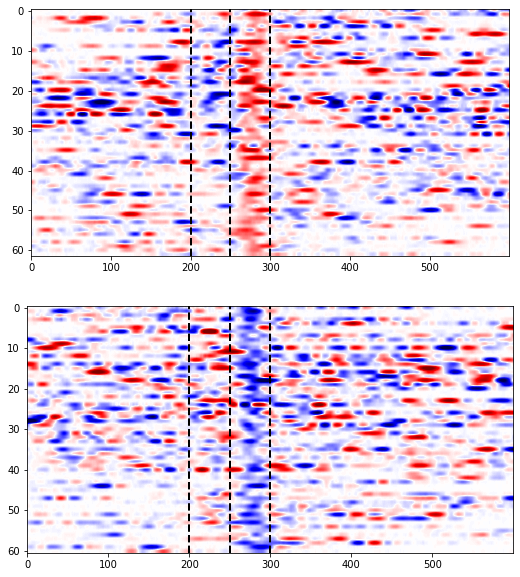

In [21]:
fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.imshow(ve_turns[180],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.subplot(212)
plt.imshow(ve_turns[0],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

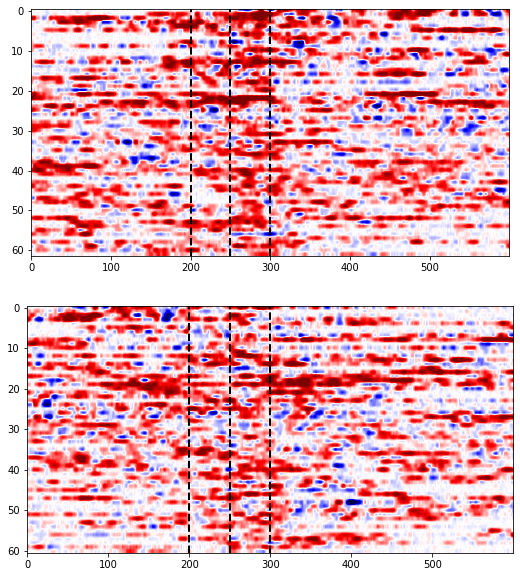

In [22]:
fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.imshow(behavior_traces_F[180][ve_turn_indicies[180],:],aspect=5,cmap='seismic',vmin=-5,vmax=5)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.subplot(212)
plt.imshow(behavior_traces_F[0][ve_turn_indicies[0],:],aspect=5,cmap='seismic',vmin=-5,vmax=5)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

In [23]:
ve_turns[0].shape

(61, 600)

In [24]:
start = 100
stop = 200

early_turn = {}
early_fwd ={}
for angle in [0,180]:
    early_turn[angle] = np.mean(np.abs(ve_turns[angle][:,start:stop]),axis=1)
    fwd_matrix = behavior_traces_F[angle][ve_turn_indicies[angle],:]
    early_fwd[angle] = np.mean(np.abs(fwd_matrix[:,start:stop]),axis=1)

In [25]:
fwd_thresh = .65
turn_thresh = 30

low_early_beh = {}
for angle in [0,180]:

    idx_T = np.where(early_turn[angle]<turn_thresh)[0]
    idx_F = np.where(early_fwd[angle]<fwd_thresh)[0]

    low_early_beh[angle] = [i for i in idx_F if i in idx_T]
    print(len(low_early_beh[angle]))

15
17


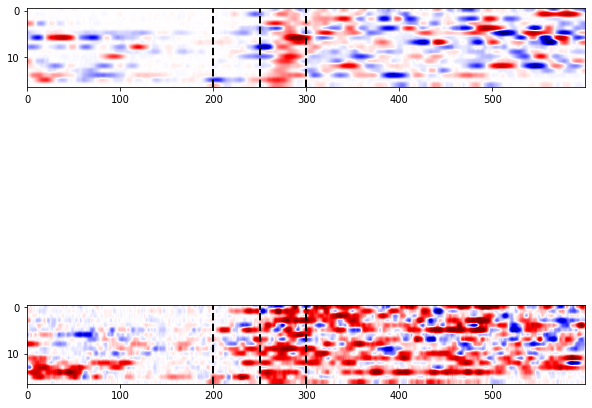

In [26]:
angle = 180

fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.imshow(ve_turns[angle][low_early_beh[angle],:],aspect=5,cmap='seismic',vmin=-300,vmax=300)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)
    
plt.subplot(212)
plt.imshow(behavior_traces_F[angle][ve_turn_indicies[angle],:][low_early_beh[angle],:],aspect=5,cmap='seismic',vmin=-5,vmax=5)
for line in [200,250,300]:
    plt.axvline(line,color='k',linestyle='--',lw=2)

In [27]:
ve_turns[0].shape

(61, 600)

(array([22., 11.,  9.,  5.,  5.,  3.,  3.,  1.,  1.,  1.]),
 array([  1.64416348,  14.00114874,  26.35813401,  38.71511927,
         51.07210453,  63.4290898 ,  75.78607506,  88.14306032,
        100.50004559, 112.85703085, 125.21401611]),
 <BarContainer object of 10 artists>)

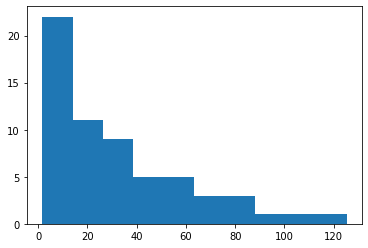

In [28]:

angle = 0

plt.hist(early_turn[angle])

# bella stop

In [26]:
### extract grey baseline ###

In [27]:
type(ve_turns[0])

numpy.ndarray

In [28]:
ve_turns[180].shape

(62, 600)

In [24]:
count_ve_180

62

In [23]:
### Percentage of ve_0,ve_180,ve_no_0,ve_no_180 ###
# (ve_180)%
count_ve_180 = ve_turns[180].shape[0]
percent_ve_180 = count_ve_180/len(starts_angle[180])*100 
# (ve_0)%
count_ve_0 = ve_turns[0].shape[0]
percent_ve_0 = count_ve_0/len(starts_angle[0])*100
# (ve_no_0)%
count_ve_no_0 = ve_no_turns[0].shape[0]
percent_ve_no_0 = count_ve_no_0/len(starts_angle[0])*100
# (ve_no_180)%
count_ve_no_180 = ve_no_turns[180].shape[0]
percent_ve_no_180 = count_ve_no_180/len(starts_angle[180])*100

In [65]:
p_ve = np.asarray([percent_ve_0,percent_ve_180])
p_ve_no =np.asarray([percent_ve_no_0,percent_ve_no_180])

In [69]:
# array([16.31016043, 16.57754011])
# Out of the 374 starts_angle_0, the fly ve_0 16.31% of the time
# Out of the 374 starts_angle_180, the fly ve_0 16.58% of the time

array([16.31016043, 16.57754011])

In [68]:
#array([16.31016043, 16.57754011])
# Out of the 374 starts_angle_0, the fly ve_no_0 16.31% of the time
# Out of the 374 starts_angle_180, the fly ve_no_0 16.58% of the time

array([16.31016043, 16.57754011])

In [29]:
########
idx_0 = np.zeros((len(starts_angle_ms[0]))) # timestamps of stimulus starts from 0 turned into 0
idx_180 = np.ones((len(starts_angle_ms[180])))# timestamps of stimulus starts from 0 turned into 1
idx = np.concatenate((idx_0, idx_180)) # concatenate idx_0 and idx_180, all 0 or 1 NOT sorted

times_ = np.concatenate((starts_angle_ms[0], starts_angle_ms[180])) # specific timestamps (not 0 or 1)

times_sorted = np.sort(times_)# sorted based on the value. Specific timestamps (not 0 or 1)

big_pool = idx[np.argsort(times_)] #0 or 1 based on their specific timestamp values
#big_pool

# argsort()
# Returns the indices that would sort an array.
# Perform an indirect sort along the given axis using the algorithm specified by the kind keyword. 
# It returns an array of indices of the same shape as a that index data along the given axis in sorted order.

### index vectors of right stimulus: r_s
### index vectors of left stimulus: l_s
stimulus_0 =[] # len = 374
stimulus_180 =[] # len = 374
for i in range(len(big_pool)):
    if big_pool[i] == 0:
        stimulus_0.append(i)
    else:
        stimulus_180.append(i)

In [40]:
####################################################################################
#### finding optomotor response trials whose previous trials were at stop stage ####
####################################################################################

#### 1. Finding the index number for idex_ve_0 and idx_vea_180 ######
idx_ve_0 = [] # len = 61
for i in range(len(ve_turn_times[0])):
    idx_ve_0.append(np.where(ve_turn_times[0][i] == times_sorted)[0][0])
idx_ve_180 = [] # len = 62
for i in range(len(ve_turn_times[180])):
    idx_ve_180.append(np.where(ve_turn_times[180][i] == times_sorted)[0][0])
    
#### 2. Finding the index number for previous trials #################
idx_ve_0_minus_1 = [index - 1 for index in idx_ve_0]
idx_ve_180_minus_1 = [index - 1 for index in idx_ve_180]

####3. Finding the index number that fly was at stop statues in the -1 index list



In [29]:
#idx_ve_0

In [33]:
consecutive_count_0 = 0
for i in range(1, len(stimulus_0)):
    if stimulus_0[i] - stimulus_0[i-1] == 1:
        consecutive_count_0 += 1

print("Number of consecutive trials in stimulus_0:", consecutive_count)


Number of consecutive trials in stimulus_0: 103


In [35]:
consecutive_count_180 = 0
for i in range(1, len(stimulus_180)):
    if stimulus_180[i] - stimulus_180[i-1] == 1:
        consecutive_count_180 += 1

print("Number of consecutive trials in stimulus_180:", consecutive_count)


Number of consecutive trials in stimulus_180: 103


In [22]:
# len(stimulus_180)
# ve_no_turns =
# ve_no_turn_times 

SyntaxError: invalid syntax (<ipython-input-22-39e082ff55a7>, line 2)

In [23]:
### index vector of right stimulus with right turn: turn_0
### index vector of left stimulus with left turn: turn_180
idx_ve_0 = [] # len = 61
for i in range(len(ve_turn_times[0])):
    idx_ve_0.append(np.where(ve_turn_times[0][i] == times_sorted)[0][0])
idx_ve_180 = [] # len = 62
for i in range(len(ve_turn_times[180])):
    idx_ve_180.append(np.where(ve_turn_times[180][i] == times_sorted)[0][0])
    
idx_ve_no_0 = [] # len = 61
for i in range(len(ve_no_turn_times[0])):
    idx_ve_no_0.append(np.where(ve_no_turn_times[0][i] == times_sorted)[0][0])
idx_ve_no_180 = [] # len = 62
for i in range(len(ve_no_turn_times[180])):
    idx_ve_no_180.append(np.where(ve_no_turn_times[180][i] == times_sorted)[0][0])
    
# ### index vector of right stimulus without right turn: wrong_0turn
# ### index vector of left stimulus without left turn: wrong_180turn    
# wrong_0turn = [i for i in r_s if i not in turn_0] # len = 321
# wrong_180turn= [i for i in l_s if i not in turn_180] # len = 349

In [24]:
idx_ve_0_minus_1 = [index - 1 for index in idx_ve_0]


In [25]:
idx_ve_0_minus_1_in_ve_0 = [] #5
idx_ve_0_minus_1_in_ve_180 = []#11
idx_ve_0_minus_1_in_ve_no_0 = []#3
idx_ve_0_minus_1_in_ve_no_180 = []#7
for i in range(len(idx_ve_0_minus_1)):
    if idx_ve_0_minus_1[i] in idx_ve_0:
        idx_ve_0_minus_1_in_ve_0.append(idx_ve_0_minus_1[i])
    elif idx_ve_0_minus_1[i] in idx_ve_180:
        idx_ve_0_minus_1_in_ve_180.append(idx_ve_0_minus_1[i])
    elif idx_ve_0_minus_1[i] in idx_ve_no_0:
        idx_ve_0_minus_1_in_ve_no_0 .append(idx_ve_0_minus_1[i])
    elif idx_ve_0_minus_1[i] in idx_ve_no_180:
        idx_ve_0_minus_1_in_ve_no_180.append(idx_ve_0_minus_1[i])


In [38]:
type(consecutive_count_0)

int

In [42]:
##### stimulus_0 in ve_0 ####
p_idx_ve_0_minus_1_in_ve_0_consec_0 = len(idx_ve_0_minus_1_in_ve_0)/consecutive_count_0
p_idx_ve_no_0_minus_1_in_ve_0_consec_0 = len(idx_ve_no_0_minus_1_in_ve_0)/consecutive_count_0

##### stimulus_0 in ve_no_0 ####
p_idx_ve_0_minus_1_in_ve_no_0_consec_0 = len(idx_ve_0_minus_1_in_ve_no_0)/consecutive_count_0
p_idx_ve_no_0_minus_1_in_ve_no_0_consec_0 = len(idx_ve_no_0_minus_1_in_ve_no_0)/consecutive_count_0

In [43]:
#### Stimulus_180 in ve_180 ####

p_idx_ve_180_minus_1_in_ve_180_consec_180=len(idx_ve_180_minus_1_in_ve_180)/consecutive_count_180
p_idx_ve_no_180_minus_1_in_ve_180_consec_180 = len(idx_ve_no_180_minus_1_in_ve_180)/consecutive_count_180

#### Stimulus_180 in ve_no_180 ####
p_idx_ve_180_minus_1_in_ve_no_180_consec_180 = len(idx_ve_180_minus_1_in_ve_no_180)/consecutive_count_180
p_idx_ve_no_180_minus_1_in_ve_no_180_consec_180 = len(idx_ve_no_180_minus_1_in_ve_no_180)/consecutive_count_180


In [46]:
[p_idx_ve_0_minus_1_in_ve_0_consec_0,p_idx_ve_no_0_minus_1_in_ve_0_consec_0]

[0.04854368932038835, 0.0]

In [47]:
[p_idx_ve_0_minus_1_in_ve_no_0_consec_0,p_idx_ve_no_0_minus_1_in_ve_no_0_consec_0]

[0.02912621359223301, 0.04854368932038835]

In [48]:
[p_idx_ve_180_minus_1_in_ve_180_consec_180,p_idx_ve_no_180_minus_1_in_ve_180_consec_180]

[0.04807692307692308, 0.019230769230769232]

In [49]:
[p_idx_ve_180_minus_1_in_ve_no_180_consec_180,p_idx_ve_no_180_minus_1_in_ve_no_180_consec_180]

[0.028846153846153848, 0.028846153846153848]

In [44]:
[p_idx_ve_0_minus_1_in_ve_0_consec_0 ,p_idx_ve_no_0_minus_1_in_ve_0_consec_0]

[0.04854368932038835, 0.0]

In [45]:
[p_idx_ve_0_minus_1_in_ve_no_0_consec_0,p_idx_ve_no_0_minus_1_in_ve_no_0_consec_0]

[0.02912621359223301, 0.04854368932038835]

In [72]:
a = [p_idx_ve_0_minus_1_in_ve_0,p_idx_ve_0_minus_1_in_ve_180 ,p_idx_ve_0_minus_1_in_ve_no_180 ,p_idx_ve_0_minus_1_in_ve_no_0]

In [73]:
#[0.08196721311475409,
 #0.18032786885245902,
 #0.11475409836065574,
 #0.04918032786885246]
# When the previous trial is ve_0, there are 8.20% of chance the current trial is also ve_0
# when the previous trial is ve_180, there are 18.03% of chance the current trial is ve_0
# when the previous trial is ve_no_180, there are 11.48% of chance the current trial is ve_0
# when the previous trial is ve_no_0, there are 4.92% of chance the current trial is ve_0

[0.08196721311475409,
 0.18032786885245902,
 0.11475409836065574,
 0.04918032786885246]

In [26]:
idx_ve_180_minus_1 = [index - 1 for index in idx_ve_180]

In [27]:
idx_ve_180_minus_1_in_ve_0 = [] #15
idx_ve_180_minus_1_in_ve_180 = []#5
idx_ve_180_minus_1_in_ve_no_0 = []#9
idx_ve_180_minus_1_in_ve_no_180 = []#3
for i in range(len(idx_ve_180_minus_1)):
    if idx_ve_180_minus_1[i] in idx_ve_0:
        idx_ve_180_minus_1_in_ve_0.append(idx_ve_180_minus_1[i])
    elif idx_ve_180_minus_1[i] in idx_ve_180:
        idx_ve_180_minus_1_in_ve_180.append(idx_ve_180_minus_1[i])
    elif idx_ve_180_minus_1[i] in idx_ve_no_0:
        idx_ve_180_minus_1_in_ve_no_0 .append(idx_ve_180_minus_1[i])
    elif idx_ve_180_minus_1[i] in idx_ve_no_180:
        idx_ve_180_minus_1_in_ve_no_180.append(idx_ve_180_minus_1[i])

In [76]:
p_idx_ve_180_minus_1_in_ve_0 = len(idx_ve_180_minus_1_in_ve_0)/len(idx_ve_180)
p_idx_ve_180_minus_1_in_ve_180 = len(idx_ve_180_minus_1_in_ve_180)/len(idx_ve_180)
p_idx_ve_180_minus_1_in_ve_no_180 = len(idx_ve_180_minus_1_in_ve_no_180)/len(idx_ve_180)
p_idx_ve_180_minus_1_in_ve_no_0 = len(idx_ve_180_minus_1_in_ve_no_0)/len(idx_ve_180)

In [77]:
[p_idx_ve_180_minus_1_in_ve_0, p_idx_ve_180_minus_1_in_ve_180,p_idx_ve_180_minus_1_in_ve_no_180, p_idx_ve_180_minus_1_in_ve_no_0]

[0.24193548387096775,
 0.08064516129032258,
 0.04838709677419355,
 0.14516129032258066]

In [ ]:
#[0.24193548387096775,
 #0.08064516129032258,
 #0.04838709677419355,
 #0.14516129032258066]
# When the previous trial is ve_0, there are 24.20% of chance the current trial is ve_180
# when the previous trial is ve_180, there are 8.06% of chance the current trial is also ve_180
# when the previous trial is ve_no_180, there are 4.84% of chance the current trial is ve_180
# when the previous trial is ve_no_0, there are 14.52% of chance the current trial is ve_180

In [28]:
idx_ve_no_180_minus_1 = [index - 1 for index in idx_ve_no_180]
idx_ve_no_0_minus_1 = [index - 1 for index in idx_ve_no_0]

In [29]:
idx_ve_no_0_minus_1_in_ve_0 = [] #0
idx_ve_no_0_minus_1_in_ve_180 = []#4
idx_ve_no_0_minus_1_in_ve_no_0 = []#5
idx_ve_no_0_minus_1_in_ve_no_180 = []#11
for i in range(len(idx_ve_no_0_minus_1)):
    if idx_ve_no_0_minus_1[i] in idx_ve_0:
        idx_ve_no_0_minus_1_in_ve_0.append(idx_ve_no_0_minus_1[i])
    elif idx_ve_no_0_minus_1[i] in idx_ve_180:
        idx_ve_no_0_minus_1_in_ve_180.append(idx_ve_no_0_minus_1[i])
    elif idx_ve_no_0_minus_1[i] in idx_ve_no_0:
        idx_ve_no_0_minus_1_in_ve_no_0 .append(idx_ve_no_0_minus_1[i])
    elif idx_ve_no_0_minus_1[i] in idx_ve_no_180:
        idx_ve_no_0_minus_1_in_ve_no_180.append(idx_ve_no_0_minus_1[i])

In [92]:
p_idx_ve_no_0_minus_1_in_ve_0 = len(idx_ve_no_0_minus_1_in_ve_0)/len(idx_ve_no_0)
p_idx_ve_no_0_minus_1_in_ve_180 = len(idx_ve_no_0_minus_1_in_ve_180)/len(idx_ve_no_0)
p_idx_ve_no_0_minus_1_in_ve_no_180 = len(idx_ve_no_0_minus_1_in_ve_no_180)/len(idx_ve_no_0)
p_idx_ve_no_0_minus_1_in_ve_no_0 = len(idx_ve_no_0_minus_1_in_ve_no_0)/len(idx_ve_no_0)

In [94]:

[p_idx_ve_no_0_minus_1_in_ve_0, p_idx_ve_no_0_minus_1_in_ve_180, p_idx_ve_no_0_minus_1_in_ve_no_180, p_idx_ve_no_0_minus_1_in_ve_no_0]


[0.0, 0.06557377049180328, 0.18032786885245902, 0.08196721311475409]

In [ ]:
#[0.0, 0.06557377049180328, 0.18032786885245902, 0.08196721311475409]
# When the previous trial is ve_0, there are 0% of chance the current trial is ve_no_0
# when the previous trial is ve_180, there are 6.56% of chance the current trial is ve_no_0
# when the previous trial is ve_no_180, there are 18.03% of chance the current trial is ve_no_0
# when the previous trial is ve_no_0, there are 8.3% of chance the current trial is ve_no_0

In [30]:
idx_ve_no_180_minus_1_in_ve_0 = [] #10
idx_ve_no_180_minus_1_in_ve_180 = []#2
idx_ve_no_180_minus_1_in_ve_no_0 = []#15
idx_ve_no_180_minus_1_in_ve_no_180 = []#3
for i in range(len(idx_ve_no_180_minus_1)):
    if idx_ve_no_180_minus_1[i] in idx_ve_0:
        idx_ve_no_180_minus_1_in_ve_0.append(idx_ve_no_180_minus_1[i])
    elif idx_ve_no_180_minus_1[i] in idx_ve_180:
        idx_ve_no_180_minus_1_in_ve_180.append(idx_ve_no_180_minus_1[i])
    elif idx_ve_no_180_minus_1[i] in idx_ve_no_0:
        idx_ve_no_180_minus_1_in_ve_no_0 .append(idx_ve_no_180_minus_1[i])
    elif idx_ve_no_180_minus_1[i] in idx_ve_no_180:
        idx_ve_no_180_minus_1_in_ve_no_180.append(idx_ve_no_180_minus_1[i])

In [90]:
p_idx_ve_no_180_minus_1_in_ve_0 = len(idx_ve_no_180_minus_1_in_ve_0)/len(idx_ve_no_180)
p_idx_ve_no_180_minus_1_in_ve_180 = len(idx_ve_no_180_minus_1_in_ve_180)/len(idx_ve_no_180)
p_idx_ve_no_180_minus_1_in_ve_no_180 = len(idx_ve_no_180_minus_1_in_ve_no_180)/len(idx_ve_no_180)
p_idx_ve_no_180_minus_1_in_ve_no_0 = len(idx_ve_no_180_minus_1_in_ve_no_0)/len(idx_ve_no_180)

In [91]:

[p_idx_ve_no_180_minus_1_in_ve_0,p_idx_ve_no_180_minus_1_in_ve_180,p_idx_ve_no_180_minus_1_in_ve_no_180,p_idx_ve_no_180_minus_1_in_ve_no_0]




[0.16129032258064516,
 0.03225806451612903,
 0.04838709677419355,
 0.24193548387096775]

In [ ]:
#[0.16129032258064516,
 #0.03225806451612903,
 #0.04838709677419355,
 #0.24193548387096775]
# When the previous trial is ve_0, there are 16.13% of chance the current trial is ve_no_180
# when the previous trial is ve_180, there are 3.22% of chance the current trial is ve_no_180
# when the previous trial is ve_no_180, there are 4.84% of chance the current trial is ve_no_180
# when the previous trial is ve_no_0, there are 24.19% of chance the current trial is ve_no_180

In [58]:
len(idx_ve_no_180_minus_1_in_ve_no_180)

3

In [36]:
count_ve_no_0 = ve_no_turns[0].shape[0]
count_ve_no_0
percent_ve_no_0 = count_ve_no_0/len(starts_angle[0])*100

In [40]:
count_ve_no_180 = ve_no_turns[180].shape[0]
count_ve_no_180
percent_ve_no_180 = count_ve_no_180/len(starts_angle[180])*100

In [31]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0] + 1)

# load neural

In [19]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

Trying to load timestamp data from hdf5 file.
Success.


In [20]:
timestamps.shape

(3384, 49)

In [21]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

In [22]:
fixed = brainsss.load_fda_meanbrain()

In [23]:
atlas = brainsss.load_roi_atlas()

In [24]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [25]:
bin_start = -1500; bin_end = 2000; bin_size = 100 # for generating 34 filters, so it is shorter 
#bin_start = -3100; bin_end = 2000; bin_size = 100
#bin_start = -3100; bin_end = 4000; bin_size = 100
#bin_start = -5100; bin_end = 6000; bin_size = 100 #for generating 110 filters, so it is longer
#bin_start = -500; bin_end = 1000; bin_size = 100

neural_bins = np.arange(bin_start,bin_end,bin_size)

In [62]:
len(neural_bins)-1

34

# extract grey baseline

In [26]:
##########################
### GET WALKING VECTOR ###
##########################

y_std = fictrac['Y']/np.std(fictrac['Y'])
z_std = fictrac['Z']/np.std(fictrac['Z'])
movement = (y_std**2 + z_std**2)**0.5
movement = scipy.ndimage.filters.gaussian_filter(movement,sigma=10)
walking = np.zeros(len(movement))
walking[np.where(movement>0.2)] = 1

In [27]:
######################
### GET GREY TIMES ###
######################

grey_starts = []
grey_stops = []
for i,stim in enumerate(stim_ids):
    if stim == 'ConstantBackground':
        grey_starts.append(stimulus_start_times[i])
        grey_stops.append(stimulus_start_times[i]+60)
grey_starts = [i*1000 for i in grey_starts] #s to ms
grey_stops = [i*1000 for i in grey_stops] #s to ms

grey_periods = np.zeros(len(walking))
for i in range(len(grey_starts)):
    grey_periods[np.where((grey_starts[i] < fictrac_timestamps) & (fictrac_timestamps < grey_stops[i]))[0]] = 1

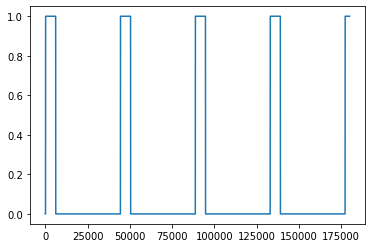

In [28]:
plt.plot(grey_periods)

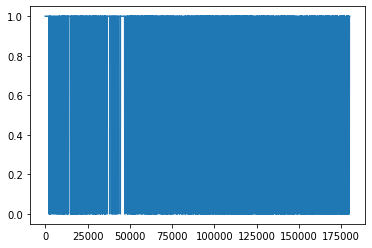

In [29]:
plt.plot(walking)

In [30]:
np.sum(walking==0), np.sum(walking==1)

(57311, 122689)

In [31]:
slice_avgs = []
for z in range(49):
    idx = np.ndarray.astype(timestamps[:,z]/10,'int')[:-1] # remove last idx because it could go over 1800s
    grey_and_stopped = np.logical_and(walking[idx] == 0, grey_periods[idx]==1)
    grey_and_walking = np.logical_and(walking[idx] == 1, grey_periods[idx]==1)
    grey_and_stopped = np.append(grey_and_stopped, False)
    slice_avgs.append(np.mean(all_signals[z,:,grey_and_stopped],axis=0))
baseline_brain = np.asarray(slice_avgs)
baseline_brain.shape
# this will be subtracted below

(49, 2000)

In [32]:
### visualize baseline ###
test = brainsss.STA_supervoxel_to_full_res(baseline_brain[:,np.newaxis,:], cluster_labels)
warp = brainsss.warp_STA_brain(STA_brain=test, fly='fly_294', fixed=fixed, anat_to_mean_type='myr')
input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
data_to_plot = warp[0][:,:,::-1]
vmax = 0.5
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                    roi_masks,
                                                    roi_contours,
                                                    data_to_plot,
                                                    input_canvas,
                                                    vmax=vmax,
                                                    cmap='seismic',
                                                    diverging=True)

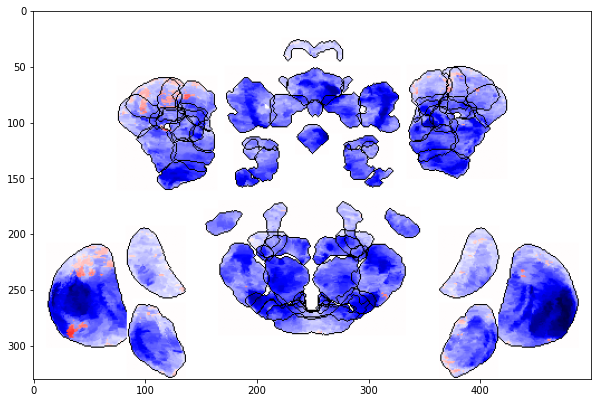

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map[170:,:])

# make STA

In [34]:
###########################
### Create Notch Filter ###
###########################

fs = 10.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = .8  # Quality factor <---- IMPORTANT
w0 = f0/(fs/2)  # Normalized Frequency

# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

# Frequency response

w, h = signal.freqz(b_notch, a_notch)

# Generate frequency axis
freq = w*fs/(2*np.pi)

# A notch filter is used in signal processing to remove a specific frequency from a signal.







In [35]:
#########################################
#### VERSION TO REMOVE EARLY BEHAVIOR ###
#########################################

bin_start = -1500; bin_end = 2000; bin_size = 200
neural_bins = np.arange(bin_start,bin_end,bin_size)

all_warps = {}
all_STA_brains ={}
for condition in ['ve_0','ve_180']:
    print(condition)
    
    if '180' in condition:
        angle = 180
    else:
        angle = 0

    event_times_list = np.asarray(ve_turn_times[angle])[low_early_beh[angle]]
    
    t0 = time.time()
    STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = event_times_list,
                                       neural_bins = neural_bins)
    print(F'STA {time.time()-t0}')

    STA_brain -= baseline_brain[:,np.newaxis,:]
    STA_brain = signal.filtfilt(b_notch, a_notch, STA_brain, axis=1)
    reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)
    STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
    
    ###yandan added this line to store all_STA_brains[condition] for later substraction
    all_STA_brains[condition] = STA_brain.copy()
    
    t0 = time.time()
    warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly=fly, fixed=fixed, anat_to_mean_type=anat_to_mean_type)
    all_warps[condition] = np.asarray(warps)
    print(F'Warps {time.time()-t0}')

ve_0


NameError: name 'low_early_beh' is not defined

In [45]:
all_warps['ve_0'].shape

(17, 314, 146, 91)

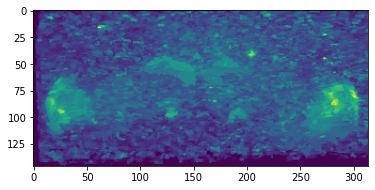

In [46]:
plt.imshow(np.max(all_warps['ve_0'][5,:,:],axis=2).T)

In [36]:
## GOOD ORIGINAL

all_warps = {}
all_STA_brains ={}
for condition in ['ve_no_0', 've_no_180','ve_0','ve_180']: #['ve_0', 've_no_0']:#['ve_no_0', 've_no_180','ve_0','ve_180']:
    print(condition)
    
    if '180' in condition:
        angle = 180
    else:
        angle = 0
    if 'no' in condition:
        event_times_list = ve_no_turn_times[angle]
    else:
        event_times_list = ve_turn_times[angle]
    
    t0 = time.time()
    STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = event_times_list,
                                       neural_bins = neural_bins)
    print(F'STA {time.time()-t0}')

    STA_brain -= baseline_brain[:,np.newaxis,:]
    STA_brain = signal.filtfilt(b_notch, a_notch, STA_brain, axis=1)
    reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)
    STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
    
    ###yandan added this line to store all_STA_brains[condition] for later substraction
    all_STA_brains[condition] = STA_brain.copy()
    
    t0 = time.time()
    warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly=fly, fixed=fixed, anat_to_mean_type=anat_to_mean_type)
    all_warps[condition] = np.asarray(warps)
    print(F'Warps {time.time()-t0}')

ve_no_0
STA 0.9454238414764404
Warps 10.844671249389648
ve_no_180
STA 1.1181650161743164
Warps 10.786455154418945
ve_0
STA 1.722158670425415
Warps 10.70105266571045
ve_180
STA 1.1575558185577393
Warps 10.283566236495972


In [51]:
np.shape(baseline_brain[:,np.newaxis,:])

(49, 1, 2000)

In [53]:
np.shape(all_warps['ve_0'])

(34, 314, 146, 91)

In [62]:
t0 = time.time()
visuomo_180_STA_brain = all_STA_brains['ve_180']-all_STA_brains['ve_no_180']
visuomo_180_warps = brainsss.warp_STA_brain(STA_brain=visuomo_180_STA_brain, fly=fly, fixed=fixed, anat_to_mean_type=anat_to_mean_type)
visuomo_180_warps = np.asarray(visuomo_180_warps)
print(F'Warps {time.time()-t0}')




Warps 13.133318901062012


In [64]:
np.shape(visuomo_180_warps)

(34, 314, 146, 91)

In [65]:
visuomo_180_explosions = []
t0 = time.time()
for tp in range(len(neural_bins)-1):
    input_canvas = np.ones((500,500,3))
    data_to_plot = visuomo_180_warps[tp,:,:,::-1]
    vmax = 1
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                           diverging=True)#'hot')
    visuomo_180_explosions.append(explosion_map)
print(F'Explosion {time.time()-t0}')


Explosion 25.09803295135498


In [66]:
def plot_panel(condition, tp, plt_num):
    plt.subplot(2,2,plt_num)
    plt.imshow(visuomo_180_explosions[tp][170:,:])
    plt.title(condition,color='k',y=.93,fontsize=12)
    plt.axis('off')

for tp in range(len(neural_bins)-1):
    print(tp)
    fig = plt.figure(figsize=(14.8,10))

    plot_panel('visuomo_0', tp, 1)
    plt.text(5,30,'Time: {}ms'.format(neural_bins[tp]),fontsize=14,color='k')
#     plot_panel('ve_no_180', tp, 2)
#     plot_panel('ve_0', tp, 3)
#     plot_panel('ve_180', tp, 4)
    plt.subplots_adjust(hspace=0,wspace=0)
    plt.suptitle(f'20240222_{fly}',y=.9)
    
    save_path = f'/oak/stanford/groups/trc/data/yandan/2P_Imaging/optomotor_response_analysis/movies/20240222_180_{fly}_movie'
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    fname = os.path.join(save_path, '{0:05d}.png'.format(tp))
    plt.savefig(fname,dpi=300,bbox_inches='tight')
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [47]:
### for no early behavior

all_explosions = {}
for condition in ['ve_0','ve_180']:#['ve_0', 've_no_0']:#['ve_no_0','ve_no_180','ve_0','ve_180']:
    explosions = []
    t0 = time.time()
    for tp in range(len(neural_bins)-1):
        input_canvas = np.ones((500,500,3))
        data_to_plot = all_warps[condition][tp,:,:,::-1]
        vmax = 1
        explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                           diverging=True)#'hot')
        explosions.append(explosion_map)
    print(F'Explosion {time.time()-t0}')
    all_explosions[condition] = explosions

Explosion 19.257997035980225
Explosion 18.138343811035156


In [49]:
def plot_panel(condition, tp, plt_num):
    plt.subplot(2,2,plt_num)
    plt.imshow(all_explosions[condition][tp][170:,:])
    plt.title(condition,color='k',y=.93,fontsize=12)
    plt.axis('off')

# fig = plt.figure(figsize=(14.8,10))
# tp=6
# plot_panel('ve_0', tp, 1)
# plot_panel('ve_180', tp, 2)
# plt.text(5,30,'Time: {}ms'.format(neural_bins[tp]),fontsize=14,color='k')

for tp in range(len(neural_bins)-1):
    print(tp)
    fig = plt.figure(figsize=(14.8,10))

    plot_panel('ve_0', tp, 1)
    plot_panel('ve_180', tp, 2)
#     plt.text(5,30,'Time: {}ms'.format(neural_bins[tp]),fontsize=14,color='k')
#     plot_panel('visuomo_0', tp, 1)
    plt.text(5,30,'Time: {}ms'.format(neural_bins[tp]),fontsize=14,color='k')
#     plot_panel('ve_no_180', tp, 2)
#     plot_panel('ve_0', tp, 3)
#     plot_panel('ve_180', tp, 4)
    plt.subplots_adjust(hspace=0,wspace=0)
    plt.suptitle(f'20240228_{fly}',y=.9)
    
    save_path = f'/oak/stanford/groups/trc/data/yandan/2P_Imaging/optomotor_response_analysis/movies/20240228_{fly}_movie'
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    fname = os.path.join(save_path, '{0:05d}.png'.format(tp))
    plt.savefig(fname,dpi=300,bbox_inches='tight')
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [42]:
all_explosions = {}
for condition in ['ve_no_0','ve_no_180','ve_0','ve_180']:#['ve_0', 've_no_0']:#['ve_no_0','ve_no_180','ve_0','ve_180']:
    explosions = []
    t0 = time.time()
    for tp in range(len(neural_bins)-1):
        input_canvas = np.ones((500,500,3))
        data_to_plot = all_warps[condition][tp,:,:,::-1]
        vmax = 1
        explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                           diverging=True)#'hot')
        explosions.append(explosion_map)
    print(F'Explosion {time.time()-t0}')
    all_explosions[condition] = explosions

Explosion 80.78157424926758
Explosion 80.61772799491882
Explosion 80.59230065345764
Explosion 80.44410252571106


In [33]:
def plot_panel(condition, tp, plt_num):
    plt.subplot(1,2,plt_num)
    plt.imshow(all_explosions[condition][tp][170:,:])
    plt.title(condition,color='k',y=.93,fontsize=12)
    plt.axis('off')

tp = 11
print(tp)
fig = plt.figure(figsize=(14.8,10))

plot_panel('ve_no_0', tp, 1)
plt.text(5,30,'Time: {}ms'.format(neural_bins[tp]),fontsize=14,color='k')
#plot_panel('ve_no_180', tp, 2)
plot_panel('ve_0', tp, 2)
#plot_panel('ve_180', tp, 4)
plt.subplots_adjust(hspace=0,wspace=0)
#plt.suptitle(f'20220524_{fly}',y=.9)

save_path = f'/oak/stanford/groups/trc/data/yandan/2P_Imaging/optomotor_response_analysis/movies/20240219_{fly}_movie'
if not os.path.exists(save_path):
    os.mkdir(save_path)
fname = os.path.join(save_path, '{0:05d}.png'.format(tp))
plt.savefig(fname,dpi=300,bbox_inches='tight')
plt.close()

11


In [97]:
# def plot_panel(condition, tp, plt_num):
#     plt.subplot(1,2,plt_num)
#     plt.imshow(all_explosions[condition][tp][170:,:])
#     plt.title(condition,color='k',y=.93,fontsize=12)
#     plt.axis('off')

# for tp in range(len(neural_bins)-1):
#     print(tp)
#     fig = plt.figure(figsize=(14.8,10))

#     plot_panel('ve_no_0', tp, 1)
#     plt.text(5,30,'Time: {}ms'.format(neural_bins[tp]),fontsize=14,color='k')
#     #plot_panel('ve_no_180', tp, 2)
#     plot_panel('ve_0', tp, 2)
#     #plot_panel('ve_180', tp, 4)
#     plt.subplots_adjust(hspace=0,wspace=0)
#     #plt.suptitle(f'20220524_{fly}',y=.9)
    
#     save_path = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20220613_{fly}_movie'
#     if not os.path.exists(save_path):
#         os.mkdir(save_path)
#     fname = os.path.join(save_path, '{0:05d}.png'.format(tp))
#     plt.savefig(fname,dpi=300,bbox_inches='tight')
#     plt.close()

In [43]:
def plot_panel(condition, tp, plt_num):
    plt.subplot(2,2,plt_num)
    plt.imshow(all_explosions[condition][tp][170:,:])
    plt.title(condition,color='k',y=.93,fontsize=12)
    plt.axis('off')

for tp in range(len(neural_bins)-1):
    print(tp)
    fig = plt.figure(figsize=(14.8,10))

    plot_panel('ve_no_0', tp, 1)
    plt.text(5,30,'Time: {}ms'.format(neural_bins[tp]),fontsize=14,color='k')
    plot_panel('ve_no_180', tp, 2)
    plot_panel('ve_0', tp, 3)
    plot_panel('ve_180', tp, 4)
    plt.subplots_adjust(hspace=0,wspace=0)
    plt.suptitle(f'20240219_{fly}',y=.9)
    
    save_path = f'/oak/stanford/groups/trc/data/yandan/2P_Imaging/optomotor_response_analysis/movies/20240220_{fly}_movie'
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    fname = os.path.join(save_path, '{0:05d}.png'.format(tp))
    plt.savefig(fname,dpi=300,bbox_inches='tight')
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109


In [45]:
# ffmpeg -an -r 3 -i %*.png -vcodec mpeg4 -b 5000k -y out.mp4

SyntaxError: invalid syntax (<ipython-input-45-98728e658c6c>, line 1)

# ROIs over time

In [37]:
all_warps['ve_0'].shape

(17, 314, 146, 91)

In [38]:
roi_ids, names = brainsss.load_roi_hemi_ids()

In [39]:
roi_signal = {}
for signal_type in ['mean']:#['max', 'mean']:
    roi_signal[signal_type] = {}
    for hemi in ['right', 'left']:
        roi_signal[signal_type][hemi] = {}
        for condition in ['ve_0','ve_180']:
            roi_signal[signal_type][hemi][condition] = brainsss.extract_roi_signal_traces(roi_ids,
                                                                                roi_masks,
                                                                                all_warps,
                                                                                condition,
                                                                                hemi,
                                                                                signal_type)

10.10600209236145
9.599275827407837
9.782020330429077
9.672868967056274


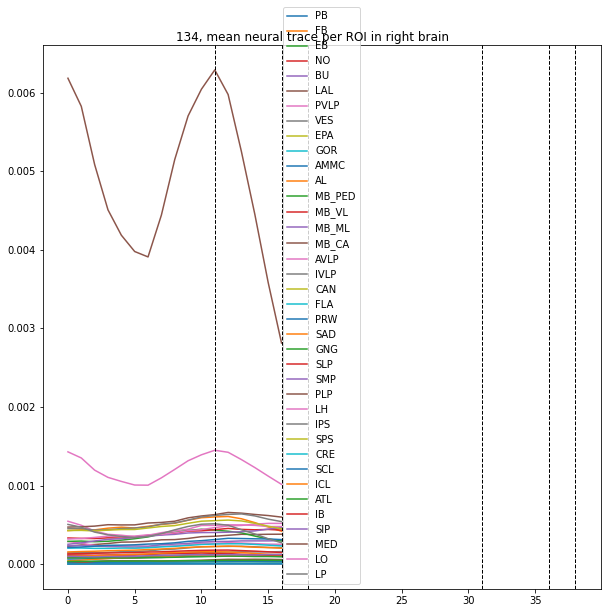

In [42]:
# Initialize plot
plt.figure(figsize=(10, 10))

# Set the identifier for the dataset
fly = 134

# Initialize dictionaries
peak_times = {}
#max_differences = {}

# Loop over each region
for region in range(38):
    # Extract signals for 'movement' and 'no movement' conditions
    move = roi_signal['mean']['right']['ve_180'][region, :]
    #no_move = roi_signal['mean']['right']['ve_no_180'][region, :]
    
    # Calculate the difference
    #difference = move - no_move
    
    # Find the peak time and store it
    peak_time = np.argmax(move)
    peak_times[names[region]] = peak_time

    # Calculate and store the maximum difference
    #max_difference = np.max(difference)
    #max_differences[names[region]] = max_difference

    # Plot the difference
    plt.plot(move, label=names[region])

# Add vertical lines for reference
vertical_lines = [11, 16, 18, 31, 36, 38]
for line in vertical_lines:
    plt.axvline(line, linestyle='--', color='k', linewidth=1)

# Add legend to the plot
plt.legend()

# Uncomment the following line if you want to limit the x-axis range
# plt.xlim(30, 60)
plt.subplots_adjust(hspace=0,wspace=0)
plt.suptitle(f'{fly}, {signal_type} neural trace per ROI in right brain',y=.9)
# Display the plot
# save_path = '/oak/stanford/groups/trc/data/yandan/2P_Imaging/optomotor_response_analysis/figs'
# timestr = time.strftime("%Y%m%d-%H%M%S")
# fname = os.path.join(save_path, f'{timestr}')
# plt.savefig(fname,dpi=300,bbox_inches='tight')
plt.show()



# Find the top 5 regions with the largest differences
# top_regions = sorted(max_differences, key=max_differences.get, reverse=True)[:15]

# # Print the top 5 regions
# print("Top 5 regions with the largest differences:")
# for region in top_regions:
#     print(f"{region}: {max_differences[region]}")

In [55]:
def extract_roi_signal_traces(roi_ids, roi_masks, all_warps, condition, hemi, signal_type):
    t0 = time.time()
    roi_time_avgs = []
    for roi in roi_ids[hemi]:
        mask = roi_masks[roi]
        masked_data = all_warps[condition][:,:,:,::-1]*mask[np.newaxis,:,:,:] #note z-flip
        if signal_type == 'max':
            roi_time_avg = np.max(masked_data,axis=(1,2,3))
        elif signal_type == 'mean':
            roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    print(time.time()-t0)
    return np.asarray(roi_time_avgs)

In [56]:
filename = os.path.join(func_path, 'STA', '20240222_yandan_STA_roi_signal_filtered_fly_134.pickle')
with open(filename, 'wb') as handle:
    pickle.dump(roi_signal, handle, protocol=pickle.HIGHEST_PROTOCOL)

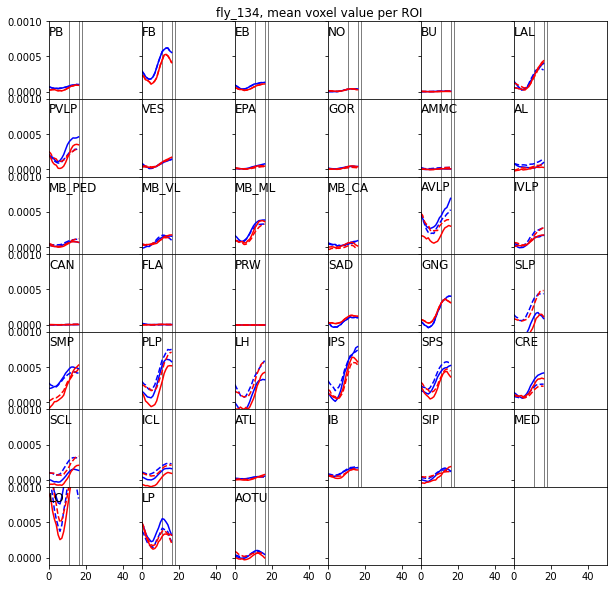

In [57]:
#full_left_group and STA_in_atlas_space_left should indeed both refer to the left brain

#right turn is blue, left turn is red
#solid line is left brain, dashed line is right brain

#so the general hypothesis is for solid lines the red should be higher, and for dashed line the blue should be higher
signal_type = 'mean'

#for max view we want x zoom in
if signal_type == 'max':
    roi_y_coor = .8
    roi_x_coor = 9
    vertical_lines = [11,16,18]
    x_start = 0#8
    x_end = 50#25
    y_start = 0
    y_end = 1
if signal_type == 'mean':
    roi_y_coor = 0.0008
    roi_x_coor = .2
    vertical_lines = [11,16,18]#[3,8,10]
    x_start = 0
    x_end = 50
    y_start = -0.0001
    y_end = 0.001

fig, ax = plt.subplots(7, 6, sharex='col', sharey='row', figsize=(10,10))
pltnum = 0
for i in range(7):
    for j in range(6):
        if pltnum == 39:
            break
        
        for line in vertical_lines:
            ax[i,j].axvline(line,linestyle='-',color='k',linewidth=.5)
        
        ax[i,j].plot(roi_signal[signal_type]['left']['ve_0'][pltnum,:],color='blue',linestyle='-')
        ax[i,j].plot(roi_signal[signal_type]['right']['ve_0'][pltnum,:],color='blue',linestyle='--')
        ax[i,j].plot(roi_signal[signal_type]['left']['ve_180'][pltnum,:],color='red',linestyle='-')
        ax[i,j].plot(roi_signal[signal_type]['right']['ve_180'][pltnum,:],color='red',linestyle='--')
        
#         ax[i,j].plot(roi_signal[signal_type]['left']['ve_no_0'][pltnum,:],color='grey',linestyle='-')
#         ax[i,j].plot(roi_signal[signal_type]['right']['ve_no_0'][pltnum,:],color='grey',linestyle='-')
#         ax[i,j].plot(roi_signal[signal_type]['left']['ve_no_180'][pltnum,:],color='grey',linestyle='-')
#         ax[i,j].plot(roi_signal[signal_type]['right']['ve_no_180'][pltnum,:],color='grey',linestyle='-')
        
        ax[i,j].text(roi_x_coor, roi_y_coor, names[pltnum],fontsize=12)
        ax[i,j].set_ylim(y_start,y_end)
        ax[i,j].set_xlim(x_start,x_end)
        
        pltnum += 1

plt.subplots_adjust(hspace=0,wspace=0)
plt.suptitle(f'{fly}, {signal_type} voxel value per ROI',y=.9)

save_path = '/oak/stanford/groups/trc/data/yandan/2P_Imaging/optomotor_response_analysis/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')


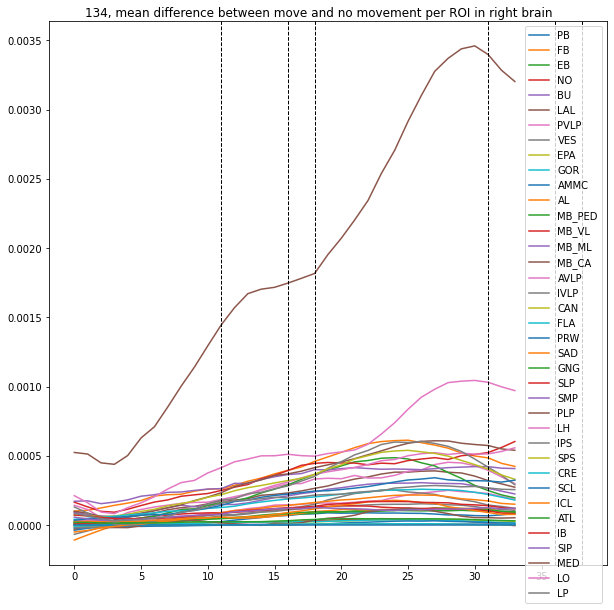

Top 5 regions with the largest differences:
MED: 0.003460366278886795
LO: 0.0010451781563460827
FB: 0.000613599200733006
PLP: 0.0006095489952713251
IPS: 0.000605006527621299
SLP: 0.0006040479056537151
LH: 0.0005587464547716081
SPS: 0.0005404609255492687
GNG: 0.000487272598547861
AVLP: 0.00045422540279105306
SMP: 0.0004229106125421822
LAL: 0.00039219020982272923
SCL: 0.0003425049362704158
MB_ML: 0.00030695126042701304
LP: 0.0002863258123397827


In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize plot
plt.figure(figsize=(10, 10))

# Set the identifier for the dataset
fly = 134

# Initialize dictionaries
peak_times = {}
max_differences = {}

# Loop over each region
for region in range(38):
    # Extract signals for 'movement' and 'no movement' conditions
    move = roi_signal['mean']['right']['ve_180'][region, :]
    no_move = roi_signal['mean']['right']['ve_no_180'][region, :]
    
    # Calculate the difference
    difference = move - no_move
    
    # Find the peak time and store it
    peak_time = np.argmax(difference)
    peak_times[names[region]] = peak_time

    # Calculate and store the maximum difference
    max_difference = np.max(difference)
    max_differences[names[region]] = max_difference

    # Plot the difference
    plt.plot(difference, label=names[region])

# Add vertical lines for reference
vertical_lines = [11, 16, 18, 31, 36, 38]
for line in vertical_lines:
    plt.axvline(line, linestyle='--', color='k', linewidth=1)

# Add legend to the plot
plt.legend()

# Uncomment the following line if you want to limit the x-axis range
# plt.xlim(30, 60)
plt.subplots_adjust(hspace=0,wspace=0)
plt.suptitle(f'{fly}, {signal_type} difference between move and no movement per ROI in right brain',y=.9)
# Display the plot
save_path = '/oak/stanford/groups/trc/data/yandan/2P_Imaging/optomotor_response_analysis/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')
plt.show()



# Find the top 5 regions with the largest differences
top_regions = sorted(max_differences, key=max_differences.get, reverse=True)[:15]

# Print the top 5 regions
print("Top 5 regions with the largest differences:")
for region in top_regions:
    print(f"{region}: {max_differences[region]}")

In [ ]:
plt.figure(figsize=(10,10))
fly = 134
peak_times = {}
max_differences = {}
for region in range(38):
    move = roi_signals[fly]['mean']['left']['ve_0'][region,:]
    no_move = roi_signals[fly]['mean']['left']['ve_no_0'][region,:]
    difference = move-no_move
    
    peak_time = np.argmax(difference)
    peak_times[names[region]] = peak_time
    
    plt.plot(difference,label=names[region])
vertical_lines = [11,16,18,31,36,38]
for line in vertical_lines:
    plt.axvline(line,linestyle='--',color='k',linewidth=1)
# for line in all_lines:
#     plt.axvline(line,linestyle='--',color='k',linewidth=1)
plt.legend()
#plt.xlim(30,60)

In [142]:
region = "LP"
region_index = names.index(region)

In [143]:
region_index

37

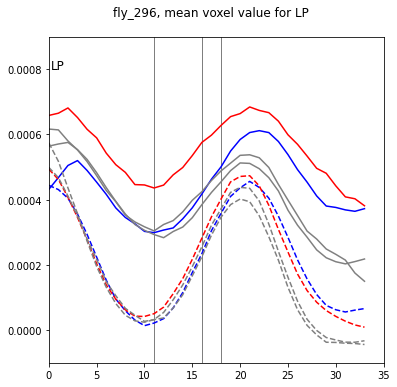

In [146]:
region = "LP"
region_index = names.index(region)
signal_type = 'mean'  # or 'max', based on your requirement

# Plot parameters
roi_y_coor = 0.0008 if signal_type == 'mean' else 0.8
roi_x_coor = 0.2 if signal_type == 'mean' else 9
vertical_lines = [11, 16, 18]
x_start, x_end = 0, 35
y_start, y_end = (-0.0001, 0.0009) if signal_type == 'mean' else (0, 1)

fig, ax = plt.subplots(figsize=(6, 6))

for line in vertical_lines:
    ax.axvline(line, linestyle='-', color='k', linewidth=0.5)

ax.plot(roi_signal[signal_type]['left']['ve_0'][region_index,:], color='blue', linestyle='-')
ax.plot(roi_signal[signal_type]['right']['ve_0'][region_index,:], color='blue', linestyle='--')
ax.plot(roi_signal[signal_type]['left']['ve_180'][region_index,:], color='red', linestyle='-')
ax.plot(roi_signal[signal_type]['right']['ve_180'][region_index,:], color='red', linestyle='--')

ax.plot(roi_signal[signal_type]['left']['ve_no_0'][region_index,:], color='grey', linestyle='-')
ax.plot(roi_signal[signal_type]['right']['ve_no_0'][region_index,:], color='grey', linestyle='--')
ax.plot(roi_signal[signal_type]['left']['ve_no_180'][region_index,:], color='grey', linestyle='-')
ax.plot(roi_signal[signal_type]['right']['ve_no_180'][region_index,:], color='grey', linestyle='--')

ax.text(roi_x_coor, roi_y_coor, f'{region}', fontsize=12)
ax.set_ylim(y_start, y_end)
ax.set_xlim(x_start, x_end)

plt.suptitle(f'{fly}, {signal_type} voxel value for {region}', y=0.95)
# Save the figure
save_path = '/oak/stanford/groups/trc/data/yandan/2P_Imaging/optomotor_response_analysis/figs'
fname = os.path.join(save_path, f'{region}_signal_{signal_type}.png')
plt.savefig(fname, dpi=300, bbox_inches='tight')

In [ ]:
#right turn is blue, left turn is red
#solid line is left brain, dashed line is right brain

In [152]:
full_right_group = {
6: 'PB',
26: 'FB',
23: 'EB',
4: 'NO',
54: 'BU_L',
56: 'LAL_L',
76: 'PVLP_L',
####################
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L',
####################
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
75: 'AVLP_L',
77: 'IVLP_L',
57: 'CAN_L',
67: 'FLA_L',
50: 'PRW',
9: 'SAD',
49: 'GNG', 
####################
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L',
###################
71: 'MED_L',
53: 'LO_L',
69: 'LP_L',
79: 'AOTU_L' 
}


In [149]:
full_left_group = {
6: 'PB',
26: 'FB',
23: 'EB',
4: 'NO',
5: 'BU_R',
8: 'LAL_R',
31: 'PVLP_R',
##################
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R',
##################
24: 'AL_R',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
30: 'AVLP_R',
32: 'IVLP_R',
10: 'CAN_R',
20: 'FLA_R',
50: 'PRW',
9: 'SAD',
49: 'GNG',
###################    
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R',
###################
25: 'MED_R',
3: 'LO_R',
22: 'LP_R',
34: 'AOTU_R'
}

In [150]:
names_1 = []
for name in full_left_group.values():
    if '_R' in name:
        names_1.append(name[:-2])
    else:
        names_1.append(name)
STA_in_atlas_space_left = {}
for condition in ['ve_0','ve_180','ve_no_0','ve_no_180']:
    t0 = time.time()
    print(condition)
    roi_time_avgs = []
    for roi in full_left_group:
        mask = roi_masks[roi]
        #masked_data = np.clip(all_warps[condition][:,:,:,::-1],0,None)*mask[np.newaxis,:,:,:]
        #roi_time_avg = np.max(masked_data,axis=(1,2,3))
        masked_data = all_warps[condition][:,:,:,::-1]*mask[np.newaxis,:,:,:]
        roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    STA_in_atlas_space_left[condition] = np.asarray(roi_time_avgs)
    print(time.time()-t0)

ve_0
10.420851945877075
ve_180
10.73926568031311
ve_no_0
10.726031064987183
ve_no_180
10.511924028396606


In [153]:
STA_in_atlas_space_right = {}
for condition in ['ve_0','ve_180','ve_no_0','ve_no_180']:
    t0 = time.time()
    print(condition)
    roi_time_avgs = []
    for roi in full_right_group:
        mask = roi_masks[roi]
        #masked_data = np.clip(all_warps[condition][:,:,:,::-1],0,None)*mask[np.newaxis,:,:,:]
        #roi_time_avg = np.max(masked_data,axis=(1,2,3))
        masked_data = all_warps[condition][:,:,:,::-1]*mask[np.newaxis,:,:,:]
        roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    STA_in_atlas_space_right[condition] = np.asarray(roi_time_avgs)
    print(time.time()-t0)

ve_0
10.475673198699951
ve_180
10.690468072891235
ve_no_0
10.875680923461914
ve_no_180
10.504641771316528


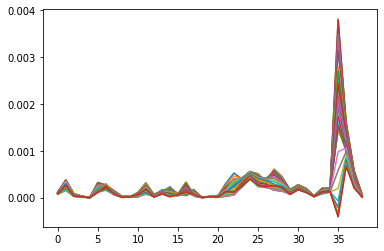

In [166]:
#plt.plot(STA_in_atlas_space_left['ve_no_0'])

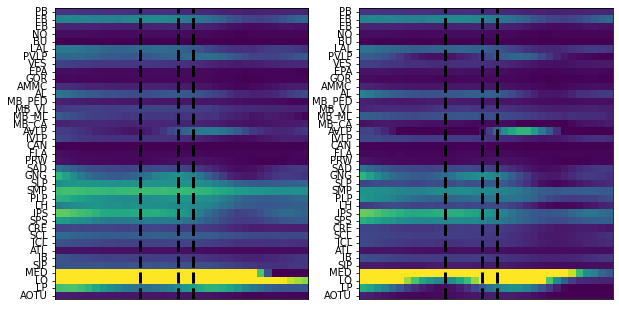

In [179]:
plt.figure(figsize=(10,10))
plt.subplot(121)
ax = plt.gca()
plt.imshow(STA_in_atlas_space_left['ve_no_0'],vmin=0,vmax=0.0008)
for line in [11,16,18]:
    plt.axvline(line,color='k',lw=3,linestyle='--')

##################
### ROI LABELS ###
##################
names_1 = []
for name in full_left_group.values():
    if '_R' in name:
        names_1.append(name[:-2])
    else:
        names_1.append(name)
#names = names[::-1] #need to swap y-order
        
ax.set_yticks([i for i in np.arange(len(names_1))]);
ax.set_xticks([]);
ax.set_yticklabels(names_1);
plt.setp(ax.get_yticklabels(), x=0, rotation=0, ha="right", va='center', fontsize=10, rotation_mode="anchor");

#################

plt.subplot(122)
ax = plt.gca()
plt.imshow(STA_in_atlas_space_right['ve_no_0'],vmin=0,vmax=.0008)
for line in [11,16,18]:
    plt.axvline(line,color='k',lw=3,linestyle='--')

##################
### ROI LABELS ###
##################
names_1 = []
for name in full_left_group.values():
    if '_R' in name:
        names_1.append(name[:-2])
    else:
        names_1.append(name)
#names = names[::-1] #need to swap y-order
        
ax.set_yticks([i for i in np.arange(len(names_1))]);
ax.set_xticks([]);
ax.set_yticklabels(names_1);
plt.setp(ax.get_yticklabels(), x=0, rotation=0, ha="right", va='center', fontsize=10, rotation_mode="anchor");

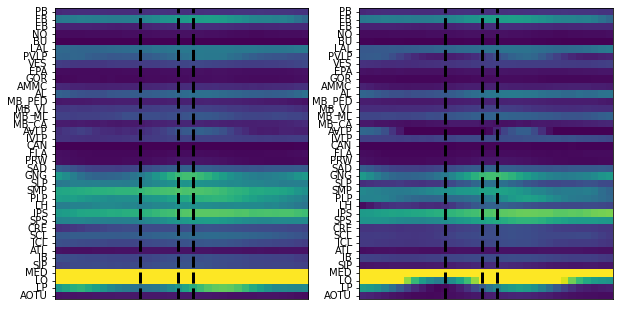

In [178]:
plt.figure(figsize=(10,10))
plt.subplot(121)
ax = plt.gca()
plt.imshow(STA_in_atlas_space_left['ve_0'],vmin=0,vmax=0.0008)
for line in [11,16,18]:
    plt.axvline(line,color='k',lw=3,linestyle='--')

##################
### ROI LABELS ###
##################
names_1 = []
for name in full_left_group.values():
    if '_R' in name:
        names_1.append(name[:-2])
    else:
        names_1.append(name)
#names = names[::-1] #need to swap y-order
        
ax.set_yticks([i for i in np.arange(len(names_1))]);
ax.set_xticks([]);
ax.set_yticklabels(names_1);
plt.setp(ax.get_yticklabels(), x=0, rotation=0, ha="right", va='center', fontsize=10, rotation_mode="anchor");

#################

plt.subplot(122)
ax = plt.gca()
plt.imshow(STA_in_atlas_space_right['ve_0'],vmin=0,vmax=.0008)
for line in [11,16,18]:
    plt.axvline(line,color='k',lw=3,linestyle='--')

##################
### ROI LABELS ###
##################
names_1 = []
for name in full_left_group.values():
    if '_R' in name:
        names_1.append(name[:-2])
    else:
        names_1.append(name)
#names = names[::-1] #need to swap y-order
        
ax.set_yticks([i for i in np.arange(len(names_1))]);
ax.set_xticks([]);
ax.set_yticklabels(names_1);
plt.setp(ax.get_yticklabels(), x=0, rotation=0, ha="right", va='center', fontsize=10, rotation_mode="anchor");

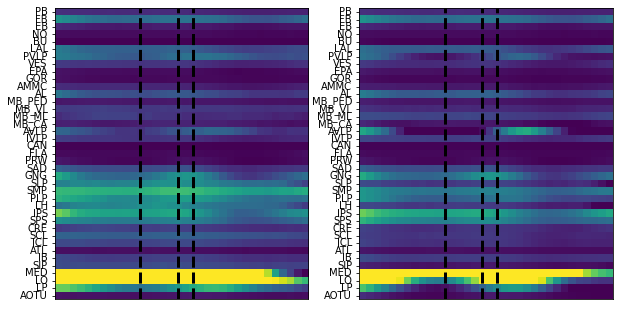

In [177]:
plt.figure(figsize=(10,10))
plt.subplot(121)
ax = plt.gca()
plt.imshow(STA_in_atlas_space_left['ve_no_180'], vmin=0,vmax=0.0008)
for line in [11,16,18]:
    plt.axvline(line,color='k',lw=3,linestyle='--')

##################
### ROI LABELS ###
##################
names_1 = []
for name in full_left_group.values():
    if '_R' in name:
        names_1.append(name[:-2])
    else:
        names_1.append(name)
#names = names[::-1] #need to swap y-order
        
ax.set_yticks([i for i in np.arange(len(names_1))]);
ax.set_xticks([]);
ax.set_yticklabels(names_1);
plt.setp(ax.get_yticklabels(), x=0, rotation=0, ha="right", va='center', fontsize=10, rotation_mode="anchor");

#################

plt.subplot(122)
ax = plt.gca()
plt.imshow(STA_in_atlas_space_right['ve_no_180'],vmin=0,vmax=.0008)
for line in [11,16,18]:
    plt.axvline(line,color='k',lw=3,linestyle='--')

##################
### ROI LABELS ###
##################
names_1 = []
for name in full_left_group.values():
    if '_R' in name:
        names_1.append(name[:-2])
    else:
        names_1.append(name)
#names = names[::-1] #need to swap y-order
        
ax.set_yticks([i for i in np.arange(len(names_1))]);
ax.set_xticks([]);
ax.set_yticklabels(names_1);
plt.setp(ax.get_yticklabels(), x=0, rotation=0, ha="right", va='center', fontsize=10, rotation_mode="anchor");